# Milk Collection

- Una compañía de procesamiento de leche necesita recolectar leche de 20 granjas y llevarla al depósito para su procesamiento.
- La compañía cuenta con un sólo tanquero de 80 mil litros de capacidad.
- 11 de las granjas son pequeñas y necesitan recolección de leche pasando un día.
- Las otras 9 granjas necesitan recolección diaria de leche.
- Encontrar la ruta óptima del tanquero para cada día teniendo en cuenta que:
    1) Debe visitar las 9 granjas que necesitan recolección diaria. 
    2) Visitar algunas granjas que necesitan recolección pasando un día y al siguiente día visitar las restantes (así como todas las granjas de recolección diaria).

<img src="tabla.png" style="width:500px;height:500px" />
<img src="ubicaciones.png" style="width:400px;height:400px" />

## Conjuntos
- $G=\{1,2,\dots,21\}$: conjunto de granjas. Depósito es el ínidice 1.
- $G_{td}=\{1,2,\dots,10\}\subset G$: subconjunto de granjas que se visitan todos los días.
- $G_{pd}=\{11,\dots,21\}\subset G$: subconjunto de granjas que se visitan pasando un día.
- $D=\{1,2\}$: conjunto de tipo de día.
- $Z \subset G_{td}\cup G_{pd}$: conjunto de los nodos en el tour.


## Parámetros
- $r_{i}$ es el requerimiento de recolección de leche de la granja $i\in G$.
- $d_{i,j}$ es la distancia entre la granja i y j. ($i<j$)
- $C=80$ es la capacidad del camión recolector (en miles de litros).

## Variables de decisión
- Sea $x_{i,j,k}$, la variable que vale 1 si en el día $k\in D$ la granja i se conecta directamente con la granja j, y cero caso contrario. ($i<j$)
- Sea $y_{i,k}$, la variable que vale 1 si la granja $i\in G_{pd}$ es visitada en el día $k\in D$, y cero caso contrario.

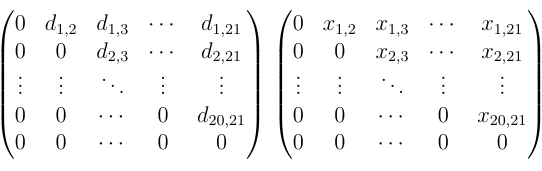

## Modelo

$$\min \sum_{i,j\in G \\ k\in D \\ i<j} d_{i,j}x_{i,j,k} $$

\begin{alignat}{2}
	& \sum_{\begin{subarray}{l}j\in G \\ i<j \end{subarray}}x_{i,j,k}+\sum_{\begin{subarray}{l}j\in G \\ j>i \end{subarray}}x_{j,i,k} = 2 && ,\; \forall i\in G_{td}, \forall k\in D \tag{1}\\
	& \sum_{\begin{subarray}{l}j\in G \\ i<j \end{subarray}}x_{i,j,k}+\sum_{\begin{subarray}{l}j\in G \\ j>i \end{subarray}}x_{j,i,k} = 2y_{i,k} && ,\; \forall i\in G_{pd}, \forall k\in D \tag{2}\\
	& y_{i,1}+y_{i,2}=1 && ,\; \forall i\in G_{pd} \tag{3}\\
	& \sum_{i\in G_{pd}}y_{i,k}r_i +\sum_{i\in G_{td}}r_i \leq 80 && ,\; \forall k \in D \tag{4}\\
    & \sum_{\begin{subarray}{l}i,j\in Z \\ i<j \end{subarray}}x_{i,j,k} \leq |Z|-1 && ,\; Z \subset G_{td} \cup G_{pd}, \forall k\in D \tag{5}\\
\end{alignat}


## Restricciones
### (1,2) Conexión:
- De cada granja que se visita "todos los días" se entra y sale una sola vez cada día.
- De cada granja que se visita "pasando un día" se entra y sale una sola vez pasando un día.

### (3) Límite de visita en granjas pasando un día:
- Las granjas que se visitan "pasando un día" se visitan en el día k=1 o k=2.

### (4) Capacidad máxima diaria:
- La cantidad de leche recolectada en el día $k \in D$ no debe exceder la capacidad máxima del camión.

### (5) Eliminación de subtours:
- Para evitar la formación de subtours se restringe la cantidad máxima de aristas.

In [1]:
import numpy as np
import pandas as pd
from gurobipy import*
from gurobipy import GRB
import math
from itertools import combinations

In [2]:
datos = pd.read_excel('posicion_granjas.xlsx')
datos = datos.drop([0], axis=0)

posiciones = datos.drop(["Collection requirement (1000 l)","Collection frequency"], axis=1)
demanda = datos.drop(["Position 10 miles","Unnamed: 2","Collection frequency"], axis=1)
frecuencia = datos.drop(["Position 10 miles","Unnamed: 2","Collection requirement (1000 l)"], axis=1)

In [3]:
# Requerimientos de recolección
r = np.array(demanda)[:,1]
r[0]=0

#Conjunto y subconjuntos de granjas
G = np.arange(21)
Gtd = G[0:10]
Gpd = G[10:21]

#tipo de días
D =[0,1]

#Capacidad máxima
C = 80

In [4]:
P = np.array(posiciones)
dist = np.zeros([21,21])
for i in range(21):
    for j in range(21):
        dist[i,j] = math.sqrt((P[i,1]-P[j,1])**2 + (P[i,2]-P[j,2])**2)

#Diccionario de distancias entre granjas
d = {(i,j): dist[i,j] for i,j in combinations(G, 2)}

In [5]:
#Modelo
milk = Model()

#variables
x = milk.addVars(d,D, vtype=GRB.BINARY, name='x')
y = milk.addVars(Gpd,D, vtype=GRB.BINARY, name='y')
  
#función objetivo
obj = quicksum(d[i,j]*x[i,j,k] for i in G for j in G for k in D if i<j)
milk.setObjective(obj, GRB.MINIMIZE)


Set parameter Username
Academic license - for non-commercial use only - expires 2022-03-24


In [6]:
#Restricciones

#Conexión
r1 = milk.addConstrs(quicksum(x[i,j,k] for j in G if i<j) + quicksum(x[j,i,k] for j in G if j<i) == 2 for i in Gtd for k in D)
r2 = milk.addConstrs(quicksum(x[i,j,k] for j in G if i<j) + quicksum(x[j,i,k] for j in G if j<i) == 2*y[i,k] for i in Gpd for k in D)

#Límite de visita en granjas pasando un día
r3 = milk.addConstrs(y[i,0]+y[i,1] == 1 for i in Gpd)

#Capacidad máxima
r4 = milk.addConstrs(quicksum(y[i,k]*r[i] for i in Gpd) + quicksum(r[i] for i in Gtd) <= C for k in D)

#Relajaciones
r5 = milk.addConstrs(x[i,j,k] <= y[i,k] for i in Gpd for j in Gpd for k in D if i<j)
r6 = milk.addConstrs(x[j,i,k] <= y[i,k] for i in Gpd for j in G for k in D if j<i)

milk.update()

## Eliminación de subtours

In [7]:
# Tuplelist de las aristas con x_{i,j,k}!=0
def selected(vals):
    s = {k:tuplelist() for k in D}
    for i,j,k in vals.keys():
        if vals[i,j,k] > 0.5:
            s[k].append((i,j))
    return s


def subtour(edges):  
    nodes = set(i for e in edges for i in e) #diferentes nodos de las tuplas en 'edges'
    unvisited = list(nodes)
    cycle = list(nodes)
    while unvisited:  
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*') if j in unvisited]
            if len(neighbors) == 0: 
                neighbors = [i for i, j in edges.select('*',current) if i in unvisited] #ya que siempre i<j
        if len(thiscycle) <= len(cycle):
            cycle = thiscycle # Ciclo más corto
    return cycle

In [8]:
# Callback - use lazy constraints to eliminate sub-tours
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        vals = model.cbGetSolution(model._x)
        edges = selected(vals)
        # encuentra el ciclo más corto en la lista de aristas seleccionada
        for k in D:
            tour = subtour(edges[k])
            if len(tour) < len(edges[k]):
                # añadir restricción de eliminación de subtours, para cada par de ciudades en el tour
                model.cbLazy(quicksum(model._x[i,j,k] for i, j in combinations(tour, 2) if i<j)
                             <= len(tour)-1)

In [9]:
milk.reset()
milk._x = x
milk.Params.lazyConstraints = 1
milk.optimize(subtourelim)

Discarded solution information
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 495 rows, 442 columns and 1786 nonzeros
Model fingerprint: 0xdbe116e1
Variable types: 0 continuous, 442 integer (442 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 11 rows and 11 columns
Presolve time: 0.04s
Presolved: 484 rows, 431 columns, 1764 nonzeros
Variable types: 0 continuous, 431 integer (431 binary)

Root relaxation: objective 1.215665e+02, 146 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  121.56645    0   20          -  121.56645      -     -    0s
H    0  

In [10]:
print('El costo de la función objetivo es: ', round(milk.ObjVal*10,2), 'millas')

El costo de la función objetivo es:  1230.56 millas


In [11]:
X1=np.zeros([21,21])
X2=np.zeros([21,21])

for i,j in d:
        for k in D:
            if k == 0:
                X1[i,j]=x[i,j,k].x
            else:
                X2[i,j]=x[i,j,k].x

Tr1 = np.argwhere(X1 == 1)
Tr2 = np.argwhere(X2 == 1)

In [12]:
b1 = np.zeros(np.shape(Tr1))
b1[0] = Tr1[0]
T1 = np.delete(Tr1,(0), axis=0)
for i in np.arange(1,Tr1.shape[0]): 
    w = np.argwhere(T1 == b1[i-1][1])
    if len(w) != 0:
        w = np.argwhere(T1 == b1[i-1][1])
        if all(T1[w[0][0]] == b1[i-1]) == False:
            b1[i] = T1[w[0][0]]
            T1 = np.delete(T1,w[0][0], axis=0)
        else:
            b1[i] = T1[w[1][0]]
            T1 = np.delete(T1,w[1][0], axis=0)
    else:
        w = np.argwhere(T1 == b1[i-1][0])
        if all(T1[w[0][0]] == b1[i-1]) == False:
            b1[i] = T1[w[0][0]]
            T1 = np.delete(T1,w[0][0], axis=0)
        else:
            b1[i] = T1[w[1][0]]
            T1 = np.delete(T1,w[1][0], axis=0)
#b1

In [13]:
b2 = np.zeros(np.shape(Tr2))
b2[0] = Tr2[0]
T2 = np.delete(Tr2,(0), axis=0)
for i in np.arange(1,Tr2.shape[0]): 
    w = np.argwhere(T2 == b2[i-1][1])
    if len(w) != 0:
        w = np.argwhere(T2 == b2[i-1][1])
        if all(T2[w[0][0]] == b2[i-1]) == False:
            b2[i] = T2[w[0][0]]
            T2 = np.delete(T2,w[0][0], axis=0)
        else:
            b2[i] = T2[w[1][0]]
            T2 = np.delete(T2,w[1][0], axis=0)
    else:
        w = np.argwhere(T2 == b2[i-1][0])
        if all(T2[w[0][0]] == b2[i-1]) == False:
            b2[i] = T2[w[0][0]]
            T2 = np.delete(T2,w[0][0], axis=0)
        else:
            b2[i] = T2[w[1][0]]
            T2 = np.delete(T2,w[1][0], axis=0)
#b2

In [14]:
header1 = pd.MultiIndex.from_product([['Tour 1'],['','']],names=['',''])
tour1 = pd.DataFrame(data=list(b1),columns=header1).astype('int')
header2 = pd.MultiIndex.from_product([['Tour 2'],['','']],names=['',''])
tour2 = pd.DataFrame(data=list(b2),columns=header2).astype('int')

In [15]:
tour1

Tour 1    
             
0       0   1
1       1  17
2       4  17
3       2   4
4       2  14
5       3  14
6       3  12
7       7  12
8       7  20
9       8  20
10      6   8
11      6  19
12      5  19
13      5   9
14      0   9

<img src="Tour1.jpg" style="width:400px;height:400px" />

In [16]:
tour2

Tour 2    
             
0       0   9
1       5   9
2       5   6
3       6  10
4       8  10
5       7   8
6       7  11
7       3  11
8       3  15
9      15  18
10      2  18
11      2  13
12      4  13
13      1   4
14      1  16
15      0  16

<img src="Tour2.jpg" style="width:400px;height:400px" />

In [17]:
visit = np.zeros([21,2])
for i in range(21):
    if len(np.argwhere(Tr1 == i)) == 0:
        visit[i,0] = 0
    else:
         visit[i,0] = 1
    if len(np.argwhere(Tr2 == i)) == 0:
        visit[i,1] = 0
    else:
         visit[i,1] = 1

In [18]:
dia = {'Día 1': list(visit[:,0]), 'Día 2': list(visit[:,1])}
dias = pd.DataFrame(data=dia).astype('int')
pd.set_option('display.colheader_justify', 'center')
dias

,Día 1,Día 2
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


## Bibliografía
- Butler, M., Williams, H.P. & Yarrow, LA. The Two-Period Travelling Salesman Problem Applied to Milk Collection in Ireland. Computational Optimization and Applications 7, 291–306 (1997). 
- Milk Collection Problem. (2021, March 05). Gurobi. https://www.gurobi.com/resource/milk-collection/
- tsp.py (2019, January 17). Gurobi. https://www.gurobi.com/documentation/9.5/examples/tsp_py.html
- Williams, P. H. (2013). Model Building in Mathematical Programming (5th ed.). Wiley.